# Trigger efficiency study

In [212]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import exists
from typing import Union, List
from hist import Hist
from hist.intervals import clopper_pearson_interval
import vector

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import hist
import mplhep as hep

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"


import sys

In [213]:

def check_selector(sample: str, selector: Union[str, List[str]]):
    if isinstance(selector, list) or isinstance(selector, tuple):     # If selector is a list or tuple
        
        for s in selector:     # Iterate over the list or tuple
            if s.startswith("*"):     # If selector starts with '*', check if the rest of the selector is in sample
                if s[1:] in sample:
                    return True
            else:
                if sample.startswith(s):
                    return True
    else:   # If selector is a single string
        if selector.startswith("*"):
            if selector[1:] in sample:
                return True
        else:
            if sample.startswith(selector):
                return True

    return False

In [214]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Reading parquets for the samples

In [215]:
data_dir = "/Users/gbibim/Here/genZ"
y = "2022"
samples = {
    "2022": {
        "Zto2Q-4Jets": ["Zto2Q-4Jets_HT-400to600", "Zto2Q-4Jets_HT-600to800", "Zto2Q-4Jets_HT-800", "Zto2Q-4Jets_HT-200to400"],
        "Zto2Q-2Jets": ["Zto2Q-2Jets_PTQQ-100to200_1J", "Zto2Q-2Jets_PTQQ-200to400_1J", "Zto2Q-2Jets_PTQQ-400to600_1J", 
                        "Zto2Q-2Jets_PTQQ-600_1J", "Zto2Q-2Jets_PTQQ-100to200_2J", "Zto2Q-2Jets_PTQQ-200to400_2J", "Zto2Q-2Jets_PTQQ-400to600_2J", "Zto2Q-2Jets_PTQQ-600_2J" ],
    },
}[y]  #This is a way to retrieve the dictionary for the year "2022" from the dictionary of samples


full_samples_list = listdir(f"{data_dir}/{y}/") # list of all samples in the directory

events_dict = {}


##### If we want all the different HT and PtQQ samples together

In [216]:
for label, selector in samples.items():  #Iterating over the dictionary of samples. Label is the key and selector is the value associated with the key
    #label = Zto2Q-4Jets
    #selector = Zto2Q-4Jets_HT-400to600, Zto2Q-4Jets_HT-200to400, Zto2Q-4Jets_HT-600

    events_dict[label] = {}  # initiates an empty list for the label key in the events_dict dictionary
    print(selector)
    
    for sample in selector:
        events_dict[label][sample] = [] 
        if not check_selector(sample, selector):    # checks if the sample is in the selector list
            print(sample)
            print("HERE")
            continue
        if not exists(f"{data_dir}/{y}/{sample}/parquet"):    #checks if the parquet file exists
            print(f"No parquet file for {sample}")
            continue


        events = pd.read_parquet(f"{data_dir}/{y}/{sample}/parquet", columns=None)
        not_empty = len(events) > 0
        if not_empty:
            events_dict[label][sample] = events
        print(f"Loaded {sample: <50}: {len(events)} entries")


    # If there are any DataFrames for the current label, concatenate them
    #if events_dict[label]:
    #    all_events = pd.concat(events_dict[label].values(), ignore_index=True)
    #    events_dict[label]['all'] = all_events  # Store the concatenated DataFrame under a special key

    # If no data was loaded for the label, delete the entry
    if not events_dict[label]:
        del events_dict[label]




['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400']
Loaded Zto2Q-4Jets_HT-400to600                           : 231480 entries
Loaded Zto2Q-4Jets_HT-600to800                           : 1493376 entries
Loaded Zto2Q-4Jets_HT-800                                : 1925423 entries
Loaded Zto2Q-4Jets_HT-200to400                           : 426 entries
['Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J']
Loaded Zto2Q-2Jets_PTQQ-100to200_1J                      : 10493 entries
Loaded Zto2Q-2Jets_PTQQ-200to400_1J                      : 2165983 entries
Loaded Zto2Q-2Jets_PTQQ-400to600_1J                      : 479076 entries
Loaded Zto2Q-2Jets_PTQQ-600_1J                           : 514662 entries
Loaded Zto2Q-2Jets_PTQQ-100to200_2J                      :

In [200]:
print(events_dict.keys())

dict_keys(['Zto2Q-4Jets', 'Zto2Q-2Jets'])


In [202]:
print(events_dict["Zto2Q-4Jets"]["Zto2Q-4Jets_HT-400to600"])

         GenVEta   GenVPhi GenVMass  GenVPt FatJetVMatch        ak8FatJetEta  \
               0         0        0       0            0      1            0   
0      -0.861328 -1.808594    90.75  206.00            0      1     0.199188   
1      -1.683594 -2.765625    90.75  252.00            1      0    -1.662354   
2       0.582031  0.363281    93.25  189.50            0      1    -0.993774   
3      -2.781250 -2.562500    91.25  112.75            0 -99999     1.744873   
4       0.355469  1.960938    91.75  297.00            1      0     0.307373   
...          ...       ...      ...     ...          ...    ...          ...   
231475 -1.089844  1.144531    90.75  262.00            1 -99999    -1.093018   
231476 -0.014160  2.085938    92.75  265.00            0      1     1.472656   
231477  2.671875  0.088135    94.50  239.50            0      1     1.130859   
231478  2.515625 -2.625000    86.50  200.50            0      1     2.211914   
231479  1.664062 -0.490234    91.50  203

In [203]:
events

GenVEta   GenVPhi GenVMass GenVPt FatJetVMatch    ak8FatJetEta  \
               0         0        0      0            0  1            0   
0      -1.011719 -0.925781    90.75  564.0            1  0    -0.989624   
1      -0.432617  2.179688    90.75  816.0            0  1    -0.766968   
2       1.304688 -1.238281    92.75  642.0            1  0     1.311035   
3       1.078125 -2.531250    92.00  648.0            1  0     1.068359   
4       0.255859 -0.615234    90.00  608.0            1  0     0.261597   
...          ...       ...      ...    ...          ... ..          ...   
535645  0.900391  2.250000    94.25  686.0            0  1     1.015381   
535646 -0.535156  1.378906    93.00  958.0            0  1    -1.364014   
535647  0.399414  0.894531    93.25  852.0            1  0     0.412170   
535648  0.656250 -1.253906    93.75  648.0            0  1     0.438965   
535649 -0.466797 -0.254883    93.50  720.0            1  0    -0.474854   

                 ak8FatJetPhi            ... AK8PFJet425_SoftDropMass40  \
               1            0         1  ...                          0   
0      -1.649170    -0.902100  1.844238  ...                          1   
1      -0.437134    -0.853760  2.180176  ...                          1   
2       1.571777    -1.236816  1.909180  ...                          0   
3       0.233795    -2.536133  0.612549  ...                          1   
4       2.502441    -0.610352  2.535645  ...                          1   
...          ...          ...       ...  ...                        ...   
535645  0.908447    -1.292236  2.265137  ...                          1   
535646 -0.538574    -2.118652  1.384033  ...                          1   
535647 -0.941406     0.901733 -2.354492  ...                          1   
535648  0.677368     2.473633 -1.256104  ...                          1   
535649  0.892578    -0.307068  2.669434  ...                          1   

       AK8PFJet400_SoftDropMass40 AK8DiPFJet250_250_MassSD50  \
                                0                          0   
0                               1                          0   
1                               1                          0   
2                               0                          0   
3                               1                          0   
4                               1                          0   
...                           ...                        ...   
535645                          1                          0   
535646                          1                          0   
535647                          1                          0   
535648                          1                          1   
535649                          1                          1   

       AK8DiPFJet260_260_MassSD30 AK8PFJet420_MassSD30  \
                                0                    0   
0                               1                    1   
1                               1                    1   
2                               0                    0   
3                               0                    1   
4                               0                    1   
...                           ...                  ...   
535645                          0                    1   
535646                          0                    1   
535647                          1                    1   
535648                          1                    1   
535649                          1                    1   

       AK8PFJet230_SoftDropMass40_PNetBB0p06  \
                                           0   
0                                      False   
1                                      False   
2                                      False   
3                                      False   
4                                      False   
...                                      ...   
535645                                 False   
535646                               

In [210]:
trigger_dict = {
    "SoftDropMass40": (
        [
            "AK8PFJet230_SoftDropMass40",
            "AK8PFJet425_SoftDropMass40",
            "AK8PFJet400_SoftDropMass40",
        ],
        "label",
    ),

    "DiPFJet": (
        [
            "AK8DiPFJet250_250_MassSD50",
            "AK8DiPFJet260_260_MassSD30",
        ],
        "label",
    ),

    "SDMass40PNet": (
        [
            "AK8PFJet230_SoftDropMass40_PNetBB0p06",
            "AK8PFJet230_SoftDropMass40_PNetBB0p10",
            "AK8PFJet250_SoftDropMass40_PNetBB0p06",
        ],
        "label",
    ),

    "ParticleNetBB0": (
        [
            "AK8PFJet230_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35",
            "AK8PFJet275_SoftDropMass40_PFAK8ParticleNetBB0p35",
        ],
        "label",
    ),
    
    "Other": (
        [
            "QuadPFJet70_50_40_35_PFBTagParticleNet_2BTagSum0p65",
            "PFHT1050",
        ],
        "label",
    )
}

In [211]:
ht_bins_fine = (25, 200, 2000)
zpt_axis = hist.axis.Regular(100, 0, 1000, name="pt", label=r"Z pT$^0$ [GeV]") #!!!
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)

hpt_fj = hist.Hist(fjpt_axis, cat_axis, sample_axis)
hpt_z = hist.Hist(zpt_axis, cat_axis, sample_axis)

for label, sample_dict in events_dict.items():
    for sample, events in sample_dict.items():
        #events = events[0]
        pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        #selection = (pt_0 > 0)
        selection = SDm > 40


        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=sample, weight=wd[selection])
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=sample, weight=wd[selection])


        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name="todas")
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name="todas")

        # Fill histograms for each trigger category
        for trigger_title, triggers in trigger_dict.items():
            trigger_selection = np.zeros_like(selection)
            for hlt in triggers:
                trigger_selection |= (events[hlt].values == 1).squeeze()
            num_selection = trigger_selection & selection

            hpt_fj.fill(pt=pt_fj[num_selection], cat=trigger_title, sample_name=sample, weight=wd[num_selection])
            hpt_z.fill(pt=pt_z[num_selection], cat=trigger_title, sample_name=sample, weight=wd[num_selection])
            
            hpt_fj.fill(pt=SDm[num_selection], cat=trigger_title, sample_name="todas", weight=wd[num_selection])
            hpt_z.fill(pt=SDm[num_selection], cat=trigger_title, sample_name="todas", weight=wd[num_selection])




ValueError: operands could not be broadcast together with shapes (231480,) (231480,3) (231480,) 

In [ ]:
import hist
import numpy as np

# Define histogram axes and initialize histograms
ht_bins_fine = (25, 200, 2000)
zpt_axis = hist.axis.Regular(100, 0, 1000, name="pt", label=r"Z pT$^0$ [GeV]")
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
sdm_axis = hist.axis.Regular(100, 0, 1000, name="SDm", label=r"SD mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)
process_axis = hist.axis.StrCategory([], name="process_name", growth=True)

hpt_fj = hist.Hist(fjpt_axis, cat_axis, sample_axis, process_axis)
hpt_z = hist.Hist(zpt_axis, cat_axis, sample_axis, process_axis)
hsd = hist.Hist(sdm_axis, cat_axis, sample_axis, process_axis)

use_default_weight = True

# Fill histograms for each sample
for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        selection = SDm_fj > 40

        # Determine weight to use
        weight = 1 if use_default_weight else wd[selection]

        # Fill histograms for the sample
        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)
        hsd.fill(SDm=SDm_fj[selection], cat="denominator", sample_name=sample_name, process_name=label, weight=weight)

        # Fill histograms for 'todas' category
        hpt_fj.fill(pt=pt_fj[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)
        hpt_z.fill(pt=pt_z[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)
        hsd.fill(SDm=SDm_fj[selection], cat="denominator", sample_name=label, process_name=label, weight=weight)

        # Fill histograms for each trigger category
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            trigger_selection = np.zeros_like(selection, dtype=bool)
            for hlt in triggers:
                trigger_selection |= (events[hlt].values == 1).squeeze()
            num_selection = trigger_selection & selection

            weight = 1 if use_default_weight else wd[num_selection]

            hpt_fj.fill(pt=pt_fj[num_selection], cat=trigger_title, sample_name=sample_name, process_name=label, weight=weight)
            hpt_z.fill(pt=pt_z[num_selection], cat=trigger_title, sample_name=sample_name, process_name=label, weight=weight)
            hsd.fill(SDm=SDm_fj[num_selection], cat=trigger_title, sample_name=sample_name, process_name=label, weight=weight)
            
            hpt_fj.fill(pt=pt_fj[num_selection], cat=trigger_title, sample_name=label, process_name=label, weight=weight)
            hpt_z.fill(pt=pt_z[num_selection], cat=trigger_title, sample_name=label, process_name=label, weight=weight)
            hsd.fill(SDm=SDm_fj[num_selection], cat=trigger_title, sample_name=label, process_name=label, weight=weight)


In [ ]:
import matplotlib.pyplot as plt
import hist

def plot_den(hist_to_plot, output_dir, var):
    """
    Plot denominator histograms and save them to files.
    
    Args:
        hist_to_plot (dict): Dictionary of histograms to plot.
        output_dir (str): Directory where the plots will be saved.
    """
    

    for label, selector in samples.items():
        # Plot for each sample in selector
        fig, ax = plt.subplots()
        for sample in selector:
            hep.histplot(hist_to_plot[{"cat": "denominator", "sample_name": sample, "process_name": label}], ax=ax, label=sample)
        ax.legend()
        plt.title(f"Denominator Histograms for {label}")
        #plt.xlabel('Bins')
        plt.ylabel('Counts')
        plt.savefig(f"{output_dir}/{var}_denominator_{label}.png")  # Save the plot as a PNG file
        plt.close(fig)  # Close the figure to free up memory

        # Plot for the aggregate label
        fig, ax = plt.subplots()
        hep.histplot(hist_to_plot[{"cat": "denominator", "sample_name": label, "process_name": label}], ax=ax, label=label)
        ax.legend()
        plt.title(f"Denominator Histograms for All Samples - {label}")
        #plt.xlabel('Bins')
        plt.ylabel('Counts')
        plt.savefig(f"{output_dir}/{var}_denominator_all_{label}.png")  # Save the plot as a PNG file
        plt.close(fig)  # Close the figure to free up memory


    fig, ax = plt.subplots()
    for label in samples.keys():
        hep.histplot(hist_to_plot[{"cat": "denominator", "sample_name": label, "process_name": label}], ax=ax, label=label)
    ax.legend()
    plt.title(f"Denominator Comparison")
    plt.savefig(f"{output_dir}/{var}_denominator_comparison.png")

    fig, ax = plt.subplots()
    for label in samples.keys():
        hep.histplot(hist_to_plot[{"cat": "Combined", "sample_name": label, "process_name": label}], ax=ax, label=label)
    ax.legend()
    plt.title(f"Trigger Comparison")
    plt.savefig(f"{output_dir}/{var}_trigger_comparison.png")


# Define the output directory where plots will be saved
output_dir = "plots"

# Create the output directory if it does not exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)




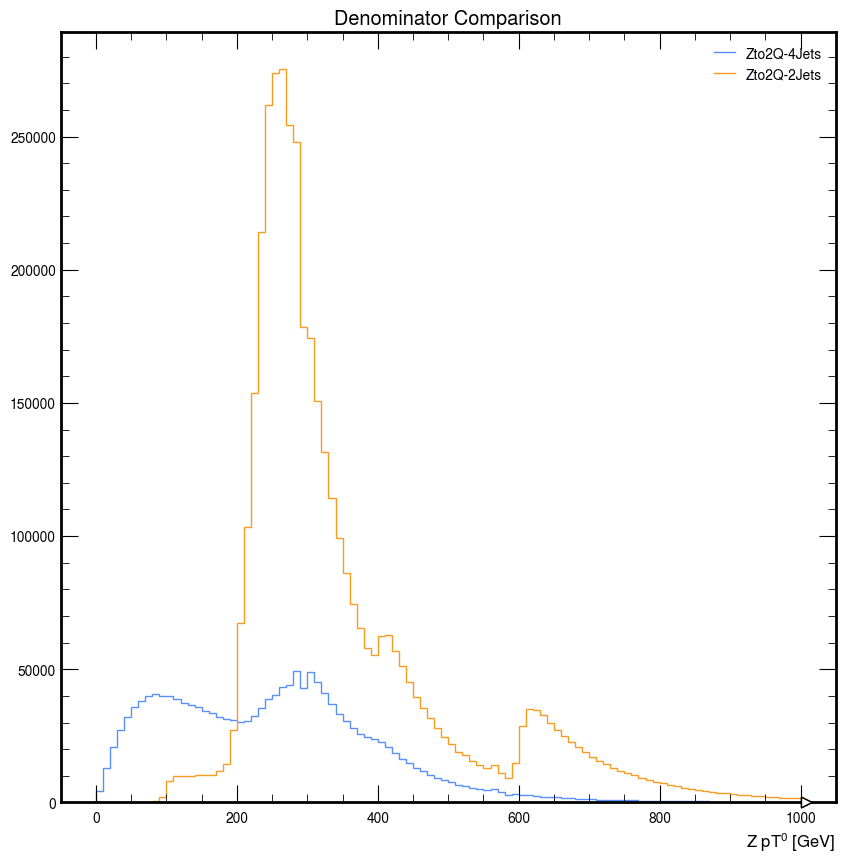

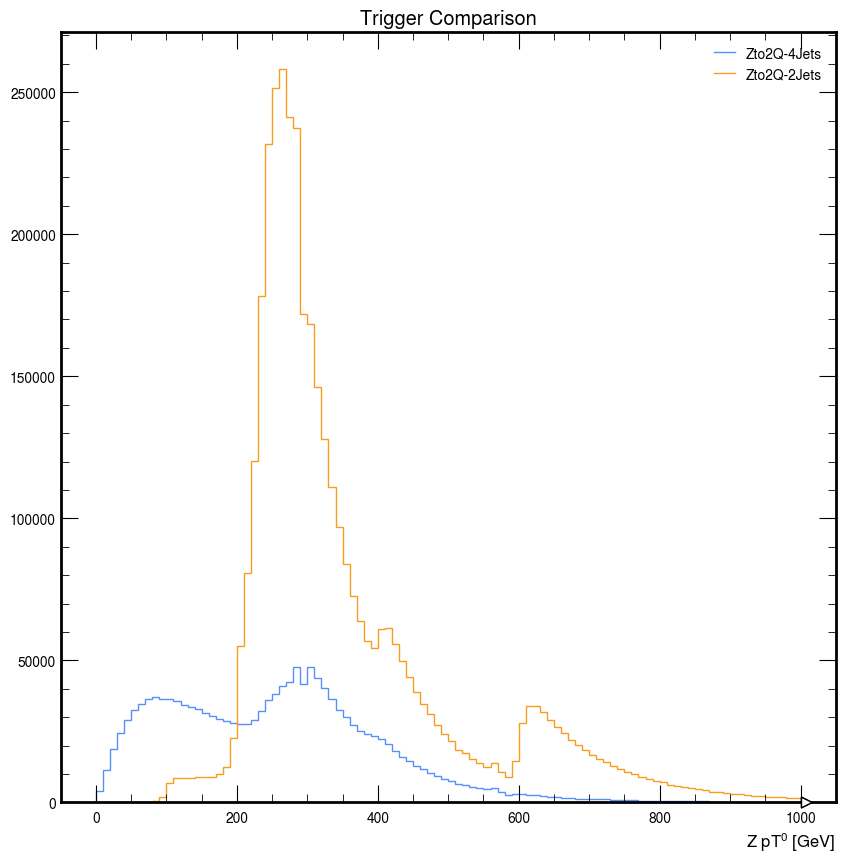

In [ ]:
# Generate and save plots
#plot_den(hsd, output_dir, var="SDm")
#plot_den(hpt_fj, output_dir, var="fjpt")
plot_den(hpt_z, output_dir, var="zpt")


In [ ]:
print(samples.items())

dict_items([('Zto2Q-4Jets', ['Zto2Q-4Jets_HT-400to600', 'Zto2Q-4Jets_HT-600to800', 'Zto2Q-4Jets_HT-800', 'Zto2Q-4Jets_HT-200to400']), ('Zto2Q-2Jets', ['Zto2Q-2Jets_PTQQ-100to200_1J', 'Zto2Q-2Jets_PTQQ-200to400_1J', 'Zto2Q-2Jets_PTQQ-400to600_1J', 'Zto2Q-2Jets_PTQQ-600_1J', 'Zto2Q-2Jets_PTQQ-100to200_2J', 'Zto2Q-2Jets_PTQQ-200to400_2J', 'Zto2Q-2Jets_PTQQ-400to600_2J', 'Zto2Q-2Jets_PTQQ-600_2J'])])


In [ ]:
import matplotlib.pyplot as plt

def plot_1d(hist_to_plot, sample, sample_label, output_dir, var):
    """
    Plot 1D histograms and save them to files.
    
    Args:
        hist_to_plot (dict): Dictionary of histograms to plot.
        sample (str): Sample name.
        sample_label (str): Label for the sample.
        output_dir (str): Directory where the plots will be saved.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        
        den = hist_to_plot[{"cat": "denominator", "sample_name": sample, "process_name": sample_label}]
        num = hist_to_plot[{"cat": trigger_title, "sample_name": sample, "process_name": sample_label}]
        hep.histplot(
            num / den,
            yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view()),
            label=triggers[0],
            ax=ax,
            flow="none",
        )
    ax.legend()
    #leg = ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")
    ax.set_ylabel("Signal Trig. Eff.")
    ax.set_ylim(0, 1)
    plt.title(f"Signal Trigger Efficiency for {sample}")
    
    # Save the plot
    plt.savefig(f"{output_dir}/{var}_signal_trigger_efficiency_{sample}.png")
    plt.close(fig)

# Define the output directory where plots will be saved
output_dir = "plots"

# Create the output directory if it does not exist
import os
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Generate and save plots
for label, selector in samples.items():
    #for sample in selector:
    plot_1d(hpt_fj, label, label, output_dir, var="fjpt")
    plot_1d(hpt_z, label, label, output_dir, var="zpt")
    plot_1d(hsd, label, label, output_dir, var="SDm")


/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/618926411.py:20: RuntimeWarning: invalid value encountered in divide
  yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/618926411.py:20: RuntimeWarning: invalid value encountered in divide
  yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/618926411.py:20: RuntimeWarning: invalid value encountered in divide
  yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/618926411.py:20: RuntimeWarning: invalid value encountered in divide
  yerr=abs(clopper_pearson_interval(num.view(), den.view()) - num.view() / den.view()),
/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/618926411.py:20: RuntimeWarning: invalid value 

# 2D hist of FatJetPt and SoftDropMass


In [ ]:
import hist
import matplotlib.pyplot as plt
import numpy as np

# Define the axes
fjpt_axis = hist.axis.Regular(100, 200, 1000, name="pt", label=r"fj pT$^0$ [GeV]")
SDm_axis = hist.axis.Regular(100, 0, 300, name="SDm", label="Soft Drop Mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
sample_axis = hist.axis.StrCategory([], name="sample_name", growth=True)

# Create the histogram
h2d = hist.Hist(fjpt_axis, SDm_axis, cat_axis, sample_axis)

In [ ]:
# Filling the histogram

for label, sample_dict in events_dict.items():
    for sample_name, events in sample_dict.items():
        #pt_z = events["GenVPt"][0]
        pt_fj = events["ak8FatJetPt"][0]
        SDm_fj = events["ak8FatJetmsoftdrop"][0]
        wd = events["weight"][0]
        
        selection = SDm_fj > 40

        # For separated samples
        #h2d.fill(pt=pt_0[selection], cat="denominator", sample_name=sample, weight=wd[selection])
        #h2d.fill(pt=pt_0, SDm=SDm_0 cat="denominator", sample_name=sample) #no weight or cuts

        #for all samples
        h2d.fill(pt=pt_fj, SDm=SDm_fj, cat="denominator", sample_name=label, weight=wd) #no weight or cuts
        for trigger_title, (triggers, trigger_label) in trigger_dict.items():
            trigger_selection = np.zeros_like(selection)
            for hlt in triggers:
                trigger_selection |= (events[hlt].values == 1).squeeze()
            num_selection = trigger_selection
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name=sample, weight=wd[num_selection & selection])
            #hpt.fill(pt=pt_0[num_selection & selection], cat=trigger_title, sample_name="todas", weight=wd[num_selection & selection])

            #h2d.fill(pt=pt_0[num_selection], SDm=SDm_0[num_selection], cat=trigger_title, sample_name=sample)
            h2d.fill(pt=pt_fj[num_selection], SDm=SDm_fj[num_selection], cat=trigger_title, sample_name=label, weight=wd[num_selection])


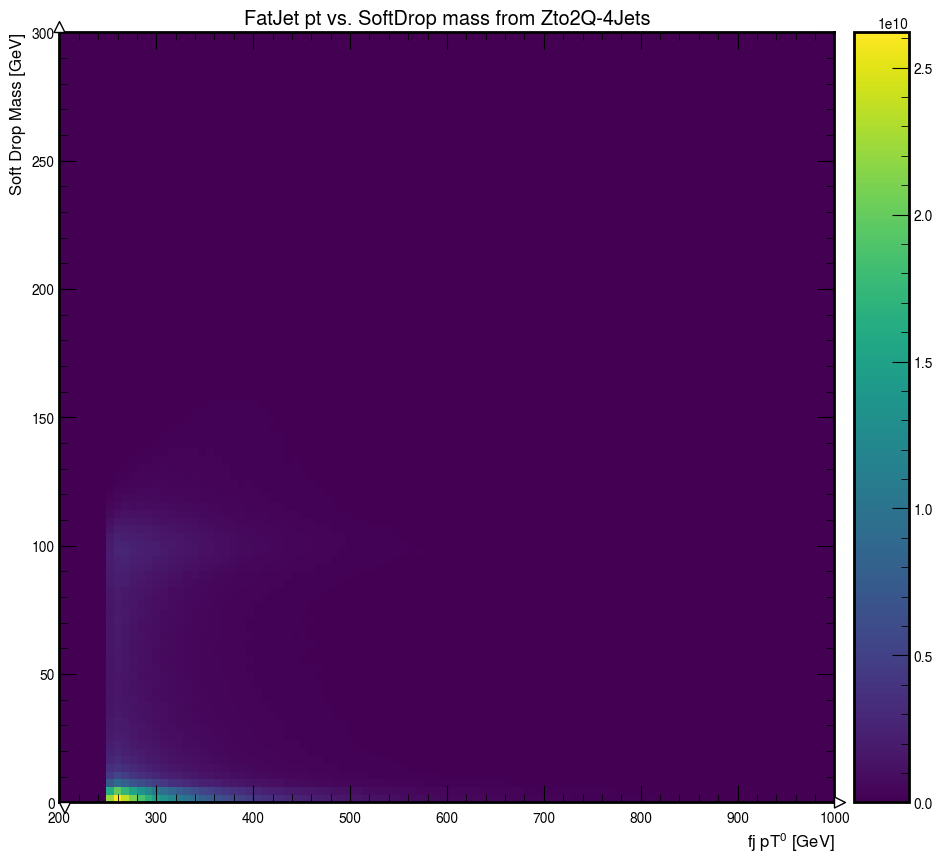

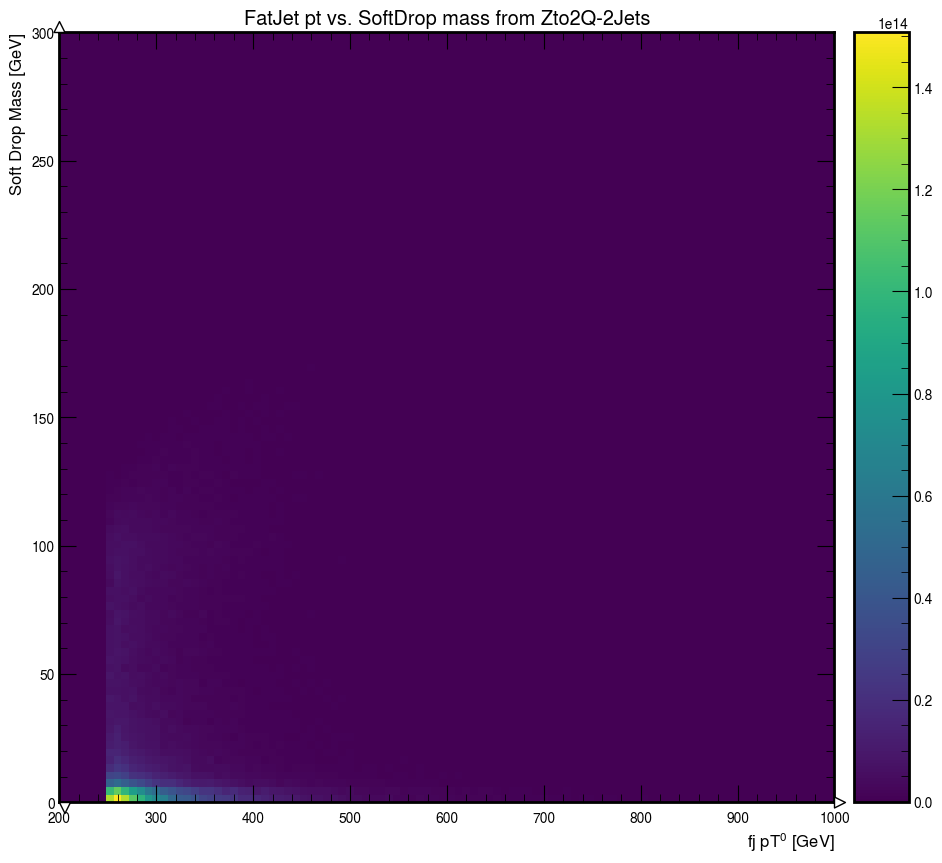

In [ ]:
# Plot the 2D histogram
for label, selector in samples.items():
    fig, ax = plt.subplots()
    hep.hist2dplot(h2d[{"cat": "denominator", "sample_name": label}], ax=ax)
    #ax.set_xlabel("X-axis Label [units]")
    #ax.set_ylabel("Y-axis Label [units]")
    plt.title(f"FatJet pt vs. SoftDrop mass from {label}")


    plt.savefig(f"{output_dir}/fjpt_vs_SDM_{label}_withWeight_noselection_notrigger.png")
    plt.show()


/var/folders/5l/g72gr7pn1qjfpv9ts3r8m3x80000gn/T/ipykernel_60870/2295520757.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


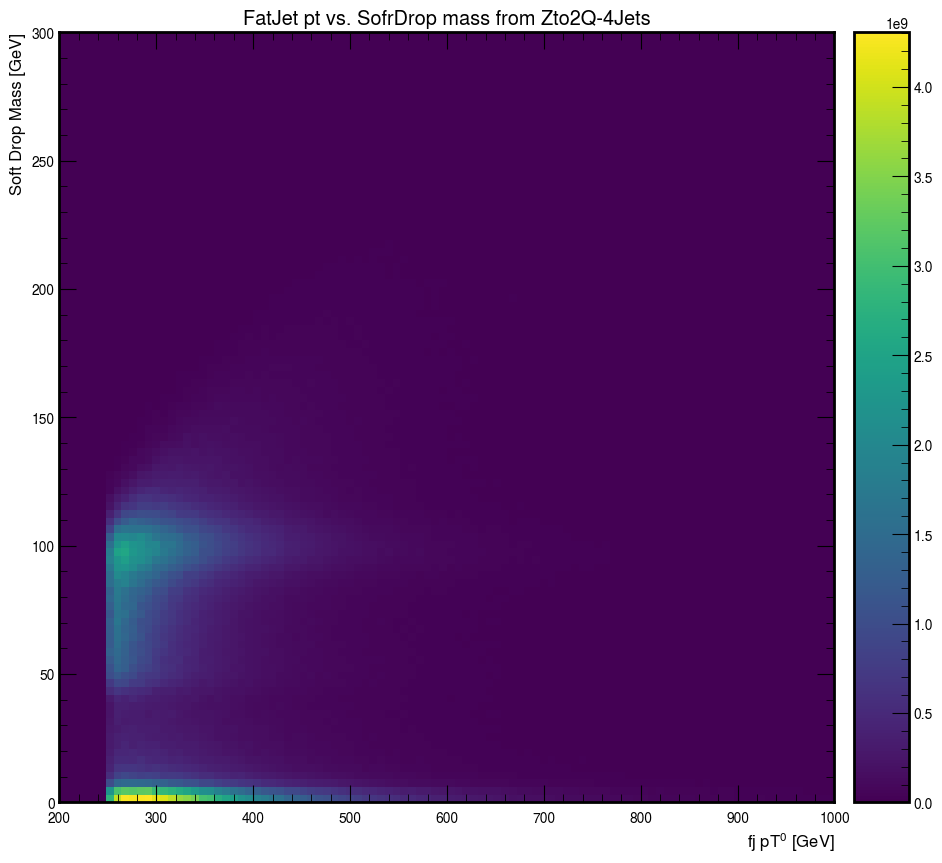

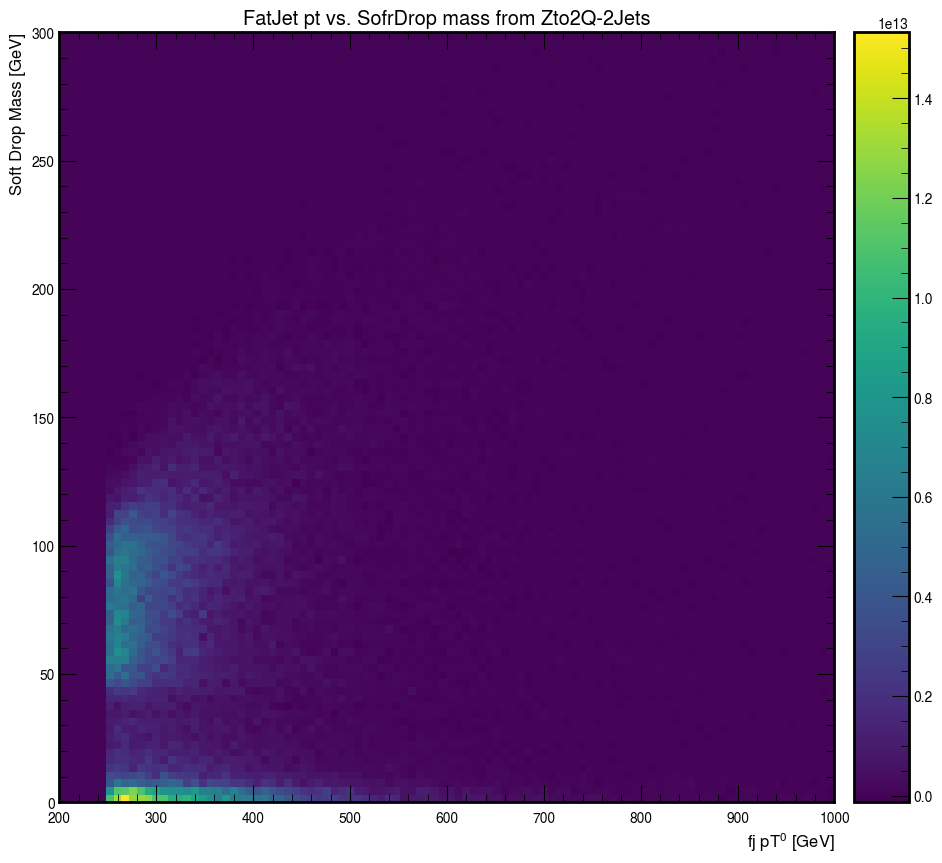

In [ ]:
for label, selector in samples.items():
    fig, ax = plt.subplots()#1, 1, figsize=(6, 4))
    for trigger_title, (triggers, trigger_label) in trigger_dict.items():
        hep.hist2dplot(h2d[{"cat": trigger_title, "sample_name": label}], ax=ax, flow="none")
        ax.legend()
    #leg = ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title(f"FatJet pt vs. SofrDrop mass from {label}")

    # Save the plot
    plt.savefig(f"{output_dir}/fjpt_vs_SDm_{label}_withWeight_noselection_withtrigger.png")
    #plt.close(fig)